In [1]:
pip install --upgrade --no-deps statsmodels

     |████████████████████████████████| 9.8 MB 5.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

WIN_SIZE = 5
DOTS_TO_PLOT = 30

## Работа с данными

### Чтение данных
Смотрите комментарии

In [3]:
g_drive = True # False если запускаем не на Google Collab
if g_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/X5/data/ads_hour.csv') # поменять путь
else:
    df = pd.read_csv('../data/ads_hour')

Mounted at /content/drive


In [4]:
df.head(2)

Date    ads
0  8/3/17 0:00  49136
1  8/3/17 1:00  46450

### Преобразование данных

In [5]:
def data_preprocessing(df):
    print('Тип столбца Date был ' + str(df['Date'].dtype))
    df['Date'] = pd.to_datetime(df['Date'])
    print(f'Тип столбца Date стал ' + str(df['Date'].dtype))

    df = df.set_index('Date').sort_index()
    return df

In [6]:
df = data_preprocessing(df)

Тип столбца Date был object
Тип столбца Date стал datetime64[ns]


In [7]:
df.head(2)

ads
Date                      
2017-08-03 00:00:00  49136
2017-08-03 01:00:00  46450

### Обработка пропущенных значений

In [8]:
print('Количество пропущенных значений: ' + str(df['ads'].isna().sum()))

Количество пропущенных значений: 0


Следующий код надо выполнять, если есть пропущенные значения. В нем мы выбираем размер окна **WIN_SIZE**. Если есть пропуски в первых **WIN_SIZE** строках, то их заполняем средним значением всей выборки (либо какой-то его части, это зависит от задачи), остальные пропущенные значения заполняем с помощью скользящего среднего.

In [9]:
if g_drive:
    df_with_na = pd.read_csv('/content/drive/MyDrive/X5/data/ads_hour_with_na.csv') # поменять путь
else:
    df_with_na = pd.read_csv('data/ads_hour_with_na')

df_with_na = data_preprocessing(df_with_na)
print('Количество пропущенных значений: ' + str(df_with_na['ads'].isna().sum()))

Тип столбца Date был object
Тип столбца Date стал datetime64[ns]
Количество пропущенных значений: 22


In [10]:
def rolling_mean_fillna(df, win_size=WIN_SIZE):
    if df.ads[:win_size].isna().sum() != 0:
        df[:win_size] = df[:win_size].fillna(round(df.ads.mean()))

    # параметры rolling  window
    # # window - размер окна
    # # center - если True, предсказываем центральный элемент окна (нам нельзя, это предсказание по будущему)
    # # min_periods - минимальное количество непропущенных значений в окне
    df['rollmean'] = df.ads.rolling(window=win_size, min_periods=1).mean() # применяется ко ВСЕМ строкам
    df['rollmean'].update(df['ads']) # меняет левый столбец на правый, если в правом не пропущенное значение
    df = df.drop(columns='ads').rename(columns={'rollmean': 'ads'})

    return df

In [13]:
df_with_na = rolling_mean_fillna(df_with_na, WIN_SIZE)

In [14]:
print('Количество пропущенных значений: ' + str(df_with_na['ads'].isna().sum()))

Количество пропущенных значений: 0


Если остаются пропущенные значения, то можно увеличить **WIN_SIZE**

In [15]:
df_with_na.head()

ads
Date                        
2017-08-03 00:00:00  49136.0
2017-08-03 01:00:00  46450.0
2017-08-03 02:00:00  46355.0
2017-08-03 03:00:00  66565.0
2017-08-03 04:00:00  42281.0

### Анализ временного ряда и визуализация
Возвращаемся к нашим данным  
**To do:**   
Добавить всякие умные графики, которые помогут разобраться в особенностях данных и потом подобрать параметры для моделек

#### Проверка на стационарность

In [16]:
from statsmodels.tsa.stattools import adfuller

stationarity = adfuller(df)[1]
if stationarity > 0.05:
    print(f'Ряд не стационарный, т к p-value {stationarity:.4f} > 0.05')
else:
    print(f'Ряд стационарный, т к p-value {stationarity:.4f} <= 0.05')

Ряд не стационарный, т к p-value 0.7251 > 0.05


#### Проверка на автокорреляцию

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

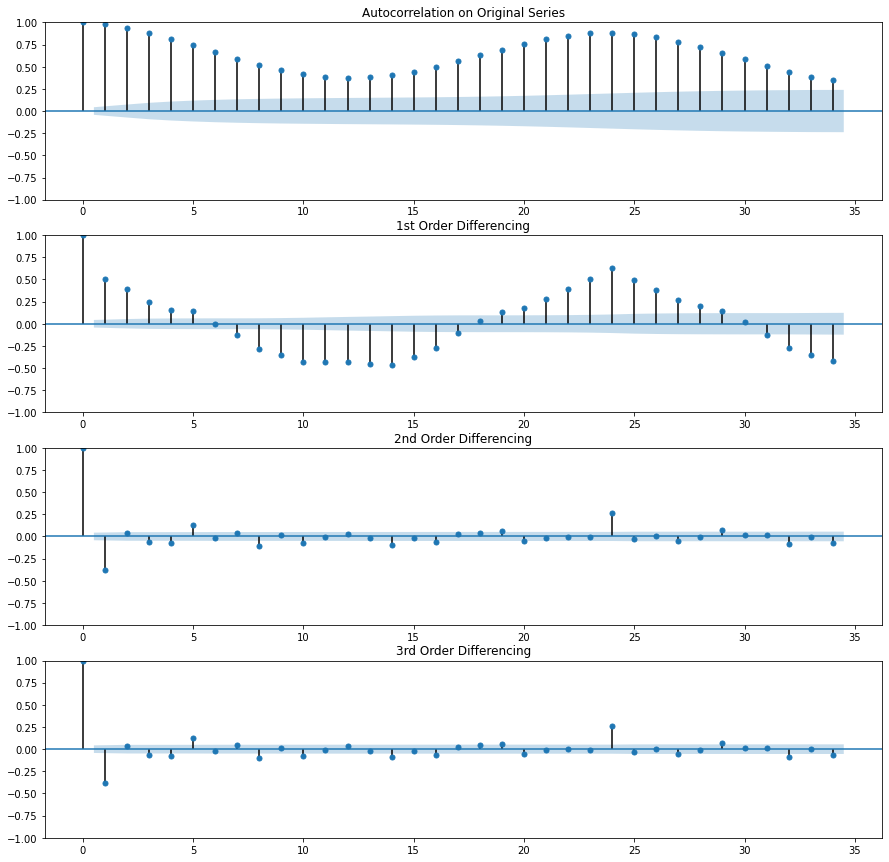

In [28]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(411)
fig = plot_acf(df, ax=ax1,
               title="Autocorrelation on Original Series")
 
ax2 = fig.add_subplot(412)
fig = plot_acf(df.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")

ax3 = fig.add_subplot(413)
fig = plot_acf(df.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

ax4 = fig.add_subplot(414)
fig = plot_acf(df.diff().diff().dropna(), ax=ax4, 
               title="3rd Order Differencing")

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


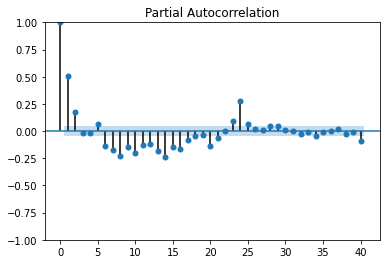

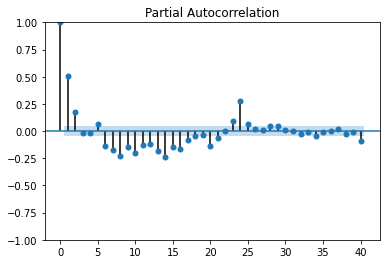

In [29]:
plot_pacf(df.diff().dropna(), lags=40)

In [12]:
stationarity[1]

0.7250990319643795

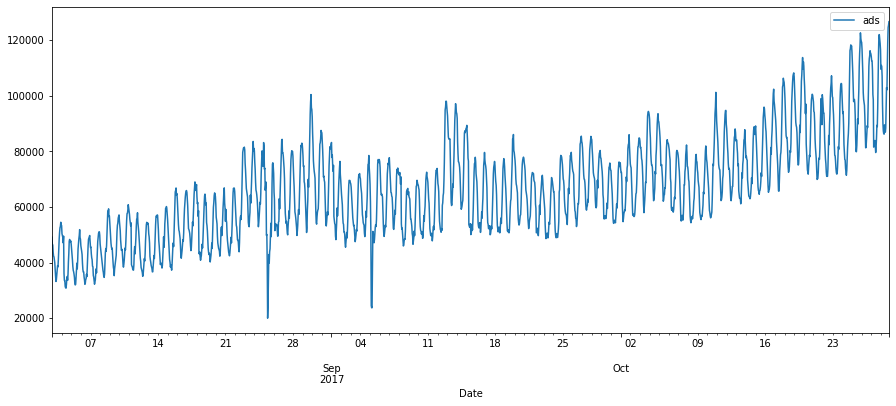

In [16]:
df.plot(figsize=(15, 6))
plt.show()

### Train-test plit

In [17]:
train_len = round(df.shape[0] * 0.8)
train, test = df[:train_len], df[train_len:]
print(train.shape)
print(test.shape)

(1668, 1)
(417, 1)


## Time Series Split Cross-Validation  
Обучающая выборка делится на **n** равных последовательных фолдов, модель обучается на **0:i**, валидируется на **i+1**. 

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

### ARIMA

#### To do
Поиграться со следующей ячейков, чтоб посмотреть на результаты предсказаний с разными параметрами.  
*ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.*

In [20]:
# import itertools
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))

In [35]:
arima_rmse = []

# Добавляем результаты с валидацией
for train_id, val_id in tss.split(train):
    tss_train, tss_val = train.iloc[train_id], train.iloc[val_id]
    model = ARIMA(tss_train, order=(1, 1, 5)).fit()
    preds = model.predict(tss_val.index[0], tss_val.index[-1])
    arima_rmse.append(np.sqrt(mean_squared_error(tss_val.ads, preds)))

# Добавим результаты без валидации
model = ARIMA(train, order=(1, 1, 5)).fit()
preds = model.predict(test.index[0], test.index[-1])
arima_rmse.append(np.sqrt(mean_squared_error(test.ads, preds)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning

In [36]:
print(arima_rmse)

[14685.977261084137, 27985.713644075262, 24161.748875389745, 11297.859972104416, 30511.481044126955]


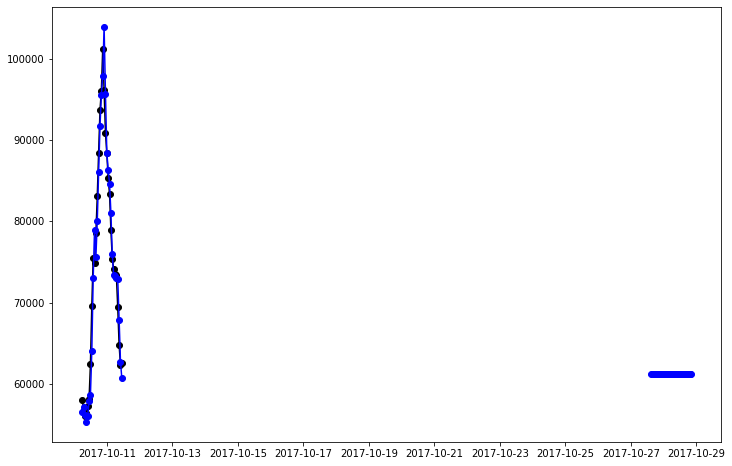

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(train[-DOTS_TO_PLOT:], marker='o', color='black')
plt.plot(model.fittedvalues[-DOTS_TO_PLOT:], marker='o', color='blue')
line1, = plt.plot(preds[-DOTS_TO_PLOT:], marker='o', color='blue')

### Exponential Smoothing
Тут тоже надо посмотреть различные параметры (например, **smoothing_level**)

In [44]:
exp_sm_rmse = []

# Добавляем результаты с валидацией
for train_id, val_id in tss.split(train):
    tss_train, tss_val = train.iloc[train_id], train.iloc[val_id]
    model = SimpleExpSmoothing(tss_train, initialization_method="heuristic").fit(smoothing_level=0.9, optimized=False)
    preds = model.predict(tss_val.index[0], tss_val.index[-1])
    exp_sm_rmse.append(np.sqrt(mean_squared_error(tss_val.ads, preds)))

# Добавим результаты без валидации
model = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.9, optimized=False)
preds = model.predict(test.index[0], test.index[-1])
exp_sm_rmse.append(np.sqrt(mean_squared_error(test.ads, preds)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [45]:
print(exp_sm_rmse)

[13890.671524433557, 23511.11639261219, 16870.02329122126, 13232.56128555985, 29282.023228209386]


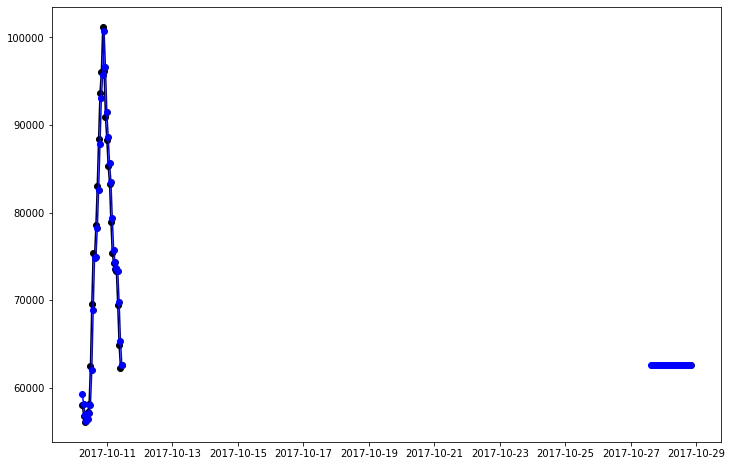

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(train[-DOTS_TO_PLOT:], marker='o', color='black')
plt.plot(model.fittedvalues[-DOTS_TO_PLOT:], marker='o', color='blue')
line1, = plt.plot(preds[-DOTS_TO_PLOT:], marker='o', color='blue')

## Blocked Cross-Validation